# Classifying Trees with Naive Bayes

**Complete by: Tuesday 2 Apr. at 9am**  
Data: (See below.)

Let's look again at our dataset of Pittsburgh's trees from last week. You might have noticed something about the different predictors you used: they were almost all categorical!

This week in class, we learned about a classifier designed specifically to work well with categorical predictors: Naive Bayes. In this week's workshop, we'll run a naive Bayes classifier on the tree data, and we'll try to determine if this is a better approach for this data than logistic regression.

## Data Wrangling

You'll need to repeat the data wrangling and cleaning steps that we did last time. **Make sure you use comments or markdown cells to explain what you're doing at each step.**

There's one big difference: last time you may have used a numerical variable, `height_M`, as a predictor. As we discussed in class, you can only use a numerical variable with naive Bayes if the variable has been "binned" into categories. It turns out that this has already been done for us with the column `height_binned_M`. **Let's use this `height_binned_M` column instead, in all instances.** Could it be that this data was designed with a naive Bayes classifier in mind?

## Building Your Model

- This time you should use one-hot encoding instead of reference coding. **Write some code to create dummy variables for your categorical predictors.**
- **Split your data into training and test sets.** How large should your test set be?
- **Create your model and fit it to the data.** Again, remember to explain and comment as you go.

## Prediction and Model Assessment

- **Create a variable to store the names of the two main *categories* we are predicting.**
- **Predict the probabilities for the test data, put them into a dataframe, and describe what you see.** Based on browsing this list, does it look like the model did a good job?
- **Predict the categories for the test data, and store this in a variable for the next steps.**
- **Visualize the confusion matrix for your model, and interpret the visualization.** Are there lots of false positives? false negatives? What could be going on here?
- **Calculate scores for accuracy, precision, and recall. Explain how your model did based on these scores.**
- **Run cross-validation and interpret the results.**
- **Visualize the ROC Curve, and calculate the AUC score for this curve. Explain how your model did based on these metrics.**

## Conclusion

**Write a one-paragraph conclusion that reflects on the two different models you ran over this past two weeks.** Which one performed better, the KNN classifier or the naive Bayes classifier? Which one is better suited to the data, and why? What other data do you wish you had to help classify these trees? What are some possible next steps for this analysis?

In [62]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score

# These replace the r-squared score and RMSE
from sklearn.metrics import confusion_matrix, classification_report,RocCurveDisplay

# You'll also need matplotlib this time
import matplotlib.pyplot as plt



## Data Wrangling

You'll need to repeat the data wrangling and cleaning steps that we did last time. **Make sure you use comments or markdown cells to explain what you're doing at each step.**

There's one big difference: last time you may have used a numerical variable, `height_M`, as a predictor. As we discussed in class, you can only use a numerical variable with naive Bayes if the variable has been "binned" into categories. It turns out that this has already been done for us with the column `height_binned_M`. **Let's use this `height_binned_M` column instead, in all instances.** Could it be that this data was designed with a naive Bayes classifier in mind? 

In [63]:
#Yes this dateset was designed with a naive Bayes classifier in mind because naives bayes uses only categorical variable, the created new categorical binned columns for a lot of their numerical features. 
#Load the dataset
pittsburgh_trees = pd.read_csv("https://datadryad.org/stash/downloads/file_stream/1764080")
#remove columns that have only null values in them
pittsburgh_trees=pittsburgh_trees.dropna(axis=1, how='all')
#replace any instance of "no_info" with an NA in the native colum
pittsburgh_trees.loc[pittsburgh_trees['native'] == 'no_info', 'native'] = np.nan
#Drop all the NAs in the native colum
pittsburgh_trees = pittsburgh_trees.dropna(subset=['native'])
#Change ward column to category data type
pittsburgh_trees['ward'] = pittsburgh_trees['ward'].astype('category')
#Drop all null values from pittsburgh_trees dataframe
new_pittsburgh_trees = pittsburgh_trees.dropna()
#Display the new dataframe
new_pittsburgh_trees

,city_ID,common_name,scientific_name,city,state,longitude_coordinate,latitude_coordinate,address,neighborhood,ward,overhead_utility,condition,height_M,native,height_binned_M,greater_metro
2,1431517397,Red maple,Acer rubrum,Pittsburgh,Pennsylvania,-79.965035,40.426797,2822 Sidney St,South side flats,16.0,No,fair,72.17848,naturally_occurring,more than 18.29 m,Pittsburgh
3,994063598,Freeman maple,Acer freemanii,Pittsburgh,Pennsylvania,-79.999276,40.455503,608 Suismon St,East allegheny,23.0,Yes,fair,82.02100,introduced,more than 18.29 m,Pittsburgh
4,1591838573,Norway maple,Acer platanoides,Pittsburgh,Pennsylvania,-79.924106,40.476667,1135 N Negley Ave,Highland park,11.0,Yes,good,170.60368,introduced,more than 18.29 m,Pittsburgh
5,1333224197,Pin oak,Quercus palustris,Pittsburgh,Pennsylvania,-79.924568,40.477496,5550 Bryant St,Highland park,11.0,No,good,147.63780,naturally_occurring,more than 18.29 m,Pittsburgh
6,239290336,Corneliancherry dogwood,Cornus mas,Pittsburgh,Pennsylvania,-79.925985,40.478403,5503 Bryant St,Highland park,11.0,Yes,good,26.24672,introduced,more than 18.29 m,Pittsburgh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45259,1777188194,Littleleaf linden,Tilia cordata,Pittsburgh,Pennsylvania,-79.925811,40.475918,5563 Hampton St,Highland park,11.0,Yes,good,147.63780,introduced,more than 18.29 m,Pittsburgh
45260,1135918275,Japanese tree lilac,Syringa reticulata,Pittsburgh,Pennsylvania,-79.925558,40.475856,5567 Hampton St,Highland park,11.0,Yes,good,49.21260,introduced,more than 18.29 m,Pittsburgh
45261,1946247732,Norway maple,Acer platanoides,Pittsburgh,Pennsylvania,-79.924299,40.476230,1129 N Negley Ave,Highland park,11.0,Yes,good,170.60368,introduced,more than 18.29 m,Pittsburgh
45262,2073822987,Northern red oak,Quercus rubra,Pittsburgh,Pennsylvania,-79.924795,40.476535,5550 Beverly Pl,Highland park,11.0,Yes,good,154.19948,naturally_occurring,more than 18.29 m,Pittsburgh


## Building Your Model

- This time you should use one-hot encoding instead of reference coding. **Write some code to create dummy variables for your categorical predictors.**
- **Split your data into training and test sets.** How large should your test set be?
- **Create your model and fit it to the data.** Again, remember to explain and comment as you go.

In [64]:
# Using the trees dataset, set an array of significant predictor variables and create one target variable
predictors = ["height_binned_M","neighborhood", "ward", "condition"]
target = "native" #Is the tree native to the state (TRUE), not native (FALSE), or of unknown status due, for example, to being only genus level (no_info)? Assignments according to BONAP data.

In [65]:
# Convert categorical variable into numerical values using one-hot encoding
X = pd.get_dummies(new_pittsburgh_trees[predictors])
y = new_pittsburgh_trees[target]

X = pd.get_dummies(new_pittsburgh_trees[predictors]) # One-hot encoding
y = new_pittsburgh_trees[target]  
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=0)

In [66]:
new_pittsburgh_trees.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30518 entries, 2 to 45263
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   city_ID               30518 non-null  int64   
 1   common_name           30518 non-null  object  
 2   scientific_name       30518 non-null  object  
 3   city                  30518 non-null  object  
 4   state                 30518 non-null  object  
 5   longitude_coordinate  30518 non-null  float64 
 6   latitude_coordinate   30518 non-null  float64 
 7   address               30518 non-null  object  
 8   neighborhood          30518 non-null  object  
 9   ward                  30518 non-null  category
 10  overhead_utility      30518 non-null  object  
 11  condition             30518 non-null  object  
 12  height_M              30518 non-null  float64 
 13  native                30518 non-null  object  
 14  height_binned_M       30518 non-null  object  
 15  greater

In [67]:
# Fit the Model  with a an alphat value of 0.01
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X_train,y_train)

MultinomialNB(alpha=0.01)

## Prediction and Model Assessment

- **Create a variable to store the names of the two main *categories* we are predicting.**
- **Predict the probabilities for the test data, put them into a dataframe, and describe what you see.** Based on browsing this list, does it look like the model did a good job?
- **Predict the categories for the test data, and store this in a variable for the next steps.**
- **Visualize the confusion matrix for your model, and interpret the visualization.** Are there lots of false positives? false negatives? What could be going on here?
- **Calculate scores for accuracy, precision, and recall. Explain how your model did based on these scores.**
- **Run cross-validation and interpret the results.**
- **Visualize the ROC Curve, and calculate the AUC score for this curve. Explain how your model did based on these metrics.**


In [68]:
#Store the names of the two main categories in categorie variable
categories = naive_model.classes_
categories

array(['introduced', 'naturally_occurring'], dtype='<U19')

In [69]:
# Get probabilities for the test data
probabilities = naive_model.predict_proba(X_test)
probabilities = pd.DataFrame(probabilities,columns = categories)
probabilities


,introduced,naturally_occurring
0,0.670117,0.329883
1,0.771511,0.228489
2,0.669520,0.330480
3,0.653857,0.346143
4,0.280990,0.719010
...,...,...
12203,0.499808,0.500192
12204,0.692876,0.307124
12205,0.829839,0.170161
12206,0.629229,0.370771


The model is not really confident in its prediction,  it prediction for "0", introduced category are a little bit over 0.5  compared to "1", naturally_occurring category which is more lower than 0.5.  This mean that the model is better at identifying introduced category compared to naturally_occuring

In [70]:
# Get categories for the test data
predictions = naive_model.predict(X_test)
predictions

array(['introduced', 'introduced', 'introduced', ..., 'introduced',
       'introduced', 'introduced'], dtype='<U19')

In [71]:
# Calculate confusion matrix and transform data
conf_mat = confusion_matrix(y_test,predictions)
conf_mat = pd.DataFrame(conf_mat,index=categories,columns=categories)
conf_mat = conf_mat.melt(ignore_index=False).reset_index()

In [72]:
# Create heatmap
heatmap = alt.Chart(conf_mat).mark_rect().encode(
    x=alt.X("variable:N").title("Predicted Response"),
    y=alt.Y("index:N").title("True Response"),
    color=alt.Color("value:Q", legend=None).scale(scheme="blues")
).properties(
    width=400,
    height=400
)
heatmap

alt.Chart(...)

In [73]:
# Add text labels for numbers
text = heatmap.mark_text(baseline="middle").encode(
    text=alt.Text("value:Q"),
    color=alt.value("black"),
    size=alt.value(50)
)

heatmap + text

alt.LayerChart(...)

The confusion matrix show that the model:

-predicted the introduced category 5651 times correctly

-predicted introduced category 3132 times incorrectly when it was naturally_occuring

-predicted naturally_occuring category 1798 times correctly

-predicted naturally_occuring 1627 times incorrectly when it was introduced

1627 prediction for false positive compared to 5651 of true positive is not that high but 3132 of false negative is a high 
number compared to 1798 of true negative. Because of the high number of the introduced category occurance (18172) compared to (12346) for the naturally_occuring category, the model is predicting more often introduced category than naturally_occuring category.

In [74]:
# You must use print to make this readable
print(classification_report(y_test, predictions))

                     precision    recall  f1-score   support

         introduced       0.64      0.78      0.70      7278
naturally_occurring       0.52      0.36      0.43      4930

           accuracy                           0.61     12208
          macro avg       0.58      0.57      0.57     12208
       weighted avg       0.60      0.61      0.59     12208



The precision of the introduced category is 64% and for the natural_occuring it is 52% which means that the model is correct 64% of time when predicting introduced category and 52% times when predicting natural_occuring category.

The recall for the introduced category is 78% while the natural_occuring is 36% which mean that the model is good at identifying the introduced category but it is bad at identifying the natural_occuring category.

The overall accuracy of the model is 61% which means that the model can accurately predict 61% of the time if a tree is naturally occuring or it is introduced.



In [75]:
scores = cross_val_score(naive_model, X, y, cv=5)
print(f"{scores.mean():.2} accuracy with standard deviation {scores.std():.2}")

0.59 accuracy with standard deviation 0.015


The 5 fold cross validation show an accuracy of 61% with a standard deviation of 6.7% which shows that there is not much variation in the accuracy performance of the model and the model can be used with a different dataset.

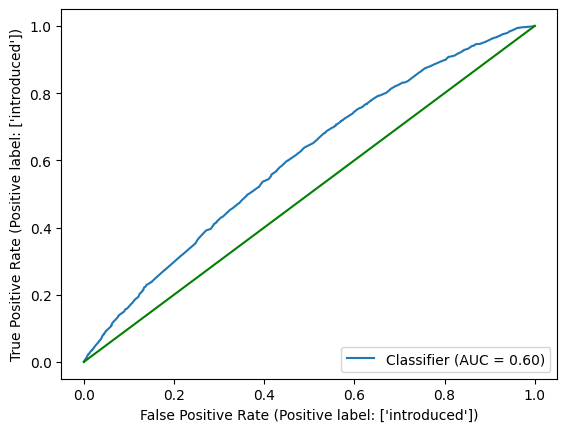

In [76]:
# Create our ROC Curve plot
RocCurveDisplay.from_predictions(y_test,
                                 probabilities[categories[0]],
                                 pos_label=[categories[0]])

# Draw a green line for 0
plt.plot([0, 1], [0, 1], color = 'g')

The AUC show that the model has a chance of 60% of identifying if a tree is naturally occurring or is introduced.

## Conclusion

**Write a one-paragraph conclusion that reflects on the two different models you ran over this past two weeks.** Which one performed better, the KNN classifier or the naive Bayes classifier? Which one is better suited to the data, and why? What other data do you wish you had to help classify these trees? What are some possible next steps for this analysis?

Considering both model, my KNN performed better than my naive bayes model. My KNN has 66% of accuracy compared to 61% for my Naives Bayes. Overall the dataset was created for a model like Naives Bayes because it contain mostly categorical data and some of the numerical variable have been binned and changed in categorical variable. I wish i could use variable like zipcode, location_type,district that can add more precision about the location of the tree. Also diameter_breast_height_binned_CM column can add more precision because tree that are native to an environment usually are bigger than the one introduced. The next step will be to solve the class imbalance between the introduced category and the natively_occuring trees by reducing the introduced class to the same level of occurance as the natively_occuring class in the dataframe. 